# LUAD CPTAC analysis

In [1]:
import pandas as pd
import numpy as np
import pickle
from sklearn.cross_decomposition import PLSRegression
from sklearn.decomposition import PCA
from msresist.figures.figure3 import plotR2YQ2Y, plotclustersIndividually, ArtificialMissingness, WinsByWeight
from msresist.figures.figure1 import pca_dfs, plotClustergram
from msresist.pre_processing import preprocessing, filter_NaNpeptides, MeanCenter, Log2T
from msresist.clustering import MassSpecClustering
from msresist.motifs import MapMotifs, FormatName
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid", font_scale=1.2, color_codes=True, palette="colorblind", rc={"grid.linestyle": "dotted", "axes.linewidth": 0.6})

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
pd.set_option('display.max_colwidth', 1000)
# pd.set_option('display.max_rows', 1000000)
# pd.set_option('display.max_columns', 1000)

## Import and Preprocess Data

In [4]:
# X = preprocessing(CPTAC=True, log2T=True)
X = pd.read_csv("msresist/data/MS/CPTAC/CPTAC-preprocessedMotfis.csv").iloc[:, 1:]

d = X.select_dtypes(include=['float64']).T
i = X.select_dtypes(include=['object'])

In [5]:
X.head()

,Sequence,Protein,Gene,Position,C3N.01799,C3N.01799.N,C3L.01890,C3L.01890.N,C3N.00572,C3N.00572.N,C3N.02423,C3N.02423.N,C3N.02729,C3N.02729.N,C3L.00263,...,C3N.00738,C3N.00738.N,C3N.00959,C3N.00959.N,C3N.02003,C3N.02003.N,C3N.02379.N,C3N.00175,C3N.00175.N,C3N.01823,C3N.01823.N,C3L.02549,C3L.02549.N,C3L.02365,C3L.02365.N
0,AAAAAsGGGVS,NP_002577.2,PBX2,S146-p,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AAAAAsQQGSA,NP_001308122.1,TBL1XR1,S119-p,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.071547,-0.600298,0.172339,-1.761406,0.421872,-0.372907,-0.979491,-0.083036,-0.361962,1.275506,-0.568015,0.25423,-0.378522,0.987749,-0.189486
2,AAAAAsTQAQQ,NP_001035540.1,MINDY2,S575-p,0.012034,-0.630863,-1.159479,-0.740044,0.107228,-0.016971,-0.023379,-0.481045,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,AAAAGsASPRS,NP_064520.2,WRNIP1,S151-p,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,AAAAGsGPSPP,NP_060895.1,PI4K2A,S44-p,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.83783,-0.993838,0.317079,...,0.031572,-0.554645,-0.033640,-1.268642,0.266790,-0.063300,-0.647500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Compare White vs Broad Quantitation

### Import White data set and Find matching values in full CPTAC data set

Import White data set:

In [6]:
white = pd.read_csv("msresist/data/MS/CPTAC/03CPTAC_filtered_White.csv").iloc[:-1, :]

Extract gene names from full protein description:

In [7]:
def FormatName(X):
    """ Keep only the general protein name, without any other accession information """
    genes = []
    counter = 0
    for v in X.iloc[:, 0]:
        if "GN" not in v:
            counter += 1
            continue
        genes.append(v.split("GN=")[1].split(" PE")[0].strip())
    print("number of proteins without gene name:", counter)
    return genes

In [8]:
genes = FormatName(white)
white = white.set_index("Protein").drop("Uncharacterized protein FLJ45252 OS=Homo sapiens OX=9606 PE=2 SV=2").reset_index()
white = white.drop("Protein", axis=1)
white.insert(1, "Gene", genes)

number of proteins without gene name: 1


Process sequences to generate +/- 5 motifs:

In [9]:
white = MapMotifs(white, white.iloc[:, 1]).drop("Position", axis=1).iloc[:, :10]

16/4669 peptides were not found in the proteome.
4653


In [10]:
white = MeanCenter(Log2T(white, list(white.columns[2:])), list(white.columns[2:]), mc_row=True, mc_col=False).sort_values(by="Sequence")

In [11]:
white.shape

(4595, 10)

Find matching patients of CPTAC data set:

In [12]:
WhiteCols = ["C3N.02587", "C3N.02587.N", "C3L.00893", "C3L.00893.N", "C3N.01488", "C3N.01488.N", "C3N.01413", "C3N.01413.N"]
cols = [X.columns[0]] + [X.columns[2]] + WhiteCols
X_tmt3 = X[cols].dropna().sort_values(by="Sequence")

Find matching peptides of CPTAC data set

In [13]:
X_tmt3 = X_tmt3.set_index(["Gene", "Sequence"])
rows = []
counter = 0
for idx in range(white.shape[0]):
    try:
        r = X_tmt3.loc[white["Gene"][idx], white["Sequence"][idx]].reset_index()
        if len(r) > 1:
            rows.append(pd.DataFrame(r.iloc[0, :]).T)
        else:
            rows.append(r)
    except:
        counter += 1
        continue
print("Number of mismatches: ", counter)

Number of mismatches:  3673


In [14]:
X_white = pd.concat(rows)
X_white = X_white.set_index(np.arange(X_white.shape[0]))

In [15]:
X_white.shape

(922, 10)

In [16]:
white = white.set_index(["Gene", "Sequence"])
rows = []
counter = 0
for idx in range(X_white.shape[0]):
    try:
        r = white.loc[X_white["Gene"][idx], X_white["Sequence"][idx]].reset_index()
        if len(r) > 1:
            rows.append(pd.DataFrame(r.iloc[0, :]).T)
        else:
            rows.append(r)
    except:
        counter += 1
print(counter)

0


In [17]:
White_X = pd.concat(rows)

In [18]:
X_white = X_white.drop_duplicates(list(X_white.columns), keep="first")

In [19]:
White_X = White_X.drop_duplicates(list(White_X.columns), keep="first")

### Heatmaps

BROAD QUANTIFICATION

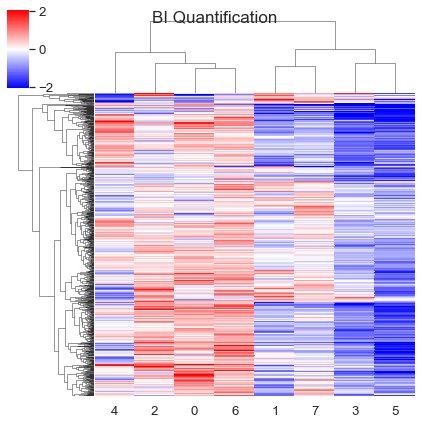

In [20]:
XW_ = X_white.set_index(["Gene"]).iloc[:, 1:]
XW_ = np.array(XW_, dtype="float64")
plotClustergram(XW_, "BI Quantification", np.max(np.abs(XW_)) * 0.3, figsize=(6,6))

WHITE QUANTIFICATION

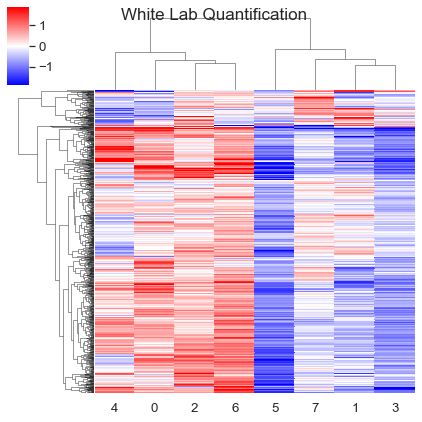

In [21]:
WX_ = White_X.set_index(["Gene"]).iloc[:, 1:]
WX_ = np.array(WX_, dtype="float64")
plotClustergram(WX_, "White Lab Quantification", np.max(np.abs(WX_)) * 0.6, figsize=(6,6))

### Model

#### BROAD

In [22]:
for i in range(2, X_white.shape[1]):
    X_white.iloc[:, i] = pd.to_numeric(X_white.iloc[:, i], errors="ignore")

In [23]:
Xd = X_white.iloc[:, 2:].T
Xi = X_white.iloc[:, :2]

In [24]:
distance_method = "PAM250"
ncl = 9
SeqWeight = 10

In [25]:
X_model = MassSpecClustering(Xi, ncl, SeqWeight=SeqWeight, distance_method=distance_method, n_runs=1).fit(Xd, "NA")

GMM initialized


In [26]:
Xcenters = X_model.transform(Xd).T

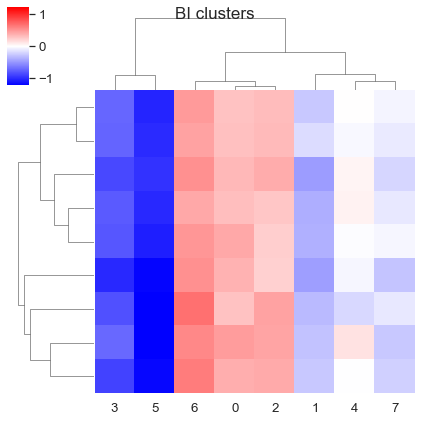

In [27]:
plotClustergram(Xcenters, "BI clusters", max(np.max(np.abs(Xcenters))) * 0.9, figsize=(6,6))

#### Cluster Averages

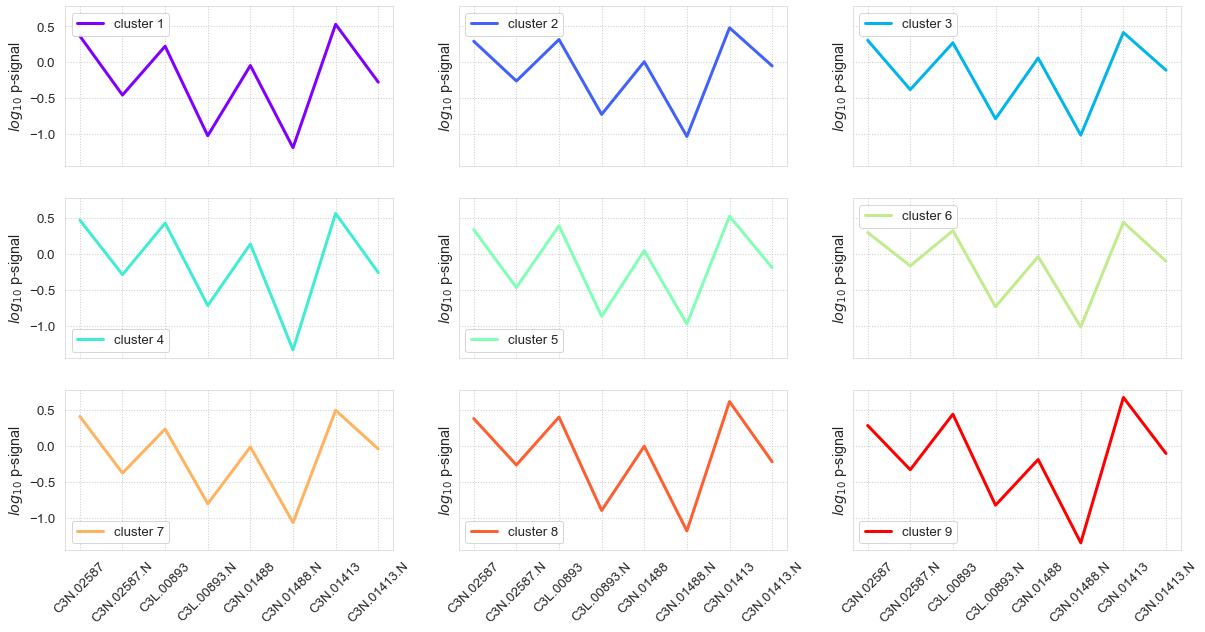

In [28]:
plotclustersIndividually(Xcenters, X_white.columns[2:], 3, 3)

#### PCA

In [29]:
Xcenters = Xcenters.T

In [30]:
Xcenters["Patient_ID"] = X_white.columns[2:]

In [31]:
c=2
pp = PCA(n_components=c)
dScor_ = pp.fit_transform(Xcenters.iloc[:, :-1])
dLoad_ = pp.components_
dScor_, dLoad_ = pca_dfs(dScor_, dLoad_, Xcenters, c, ["Patient_ID"], "Cluster")

In [32]:
dScor_.columns = ["PC1", "PC2", "Patient_ID"]

In [33]:
varExp = np.round(pp.explained_variance_ratio_, 2)
varExp

array([0.99, 0.01])

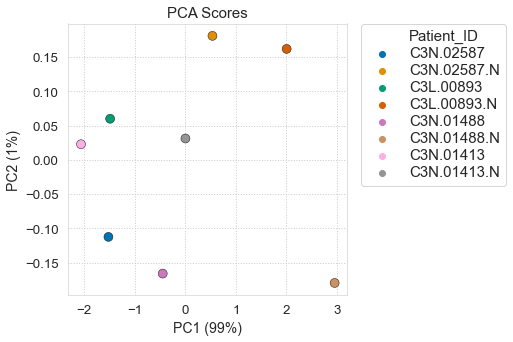

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.scatterplot(x="PC1", y="PC2", data=dScor_, hue="Patient_ID", ax=ax, s=80, **{'linewidth':.5, 'edgecolor':"k"})
ax.set_title("PCA Scores", fontsize=15)
ax.set_xlabel("PC1 (" + str(int(varExp[0] * 100)) + "%)", fontsize=14)
ax.set_ylabel("PC2 (" + str(int(varExp[1] * 100)) + "%)", fontsize=14)
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0, labelspacing=0.2, fontsize=15);
# plt.savefig("PCA_CPTAC_20cl_Scores.svg", bbox_inches='tight', format='svg', dpi=1200)

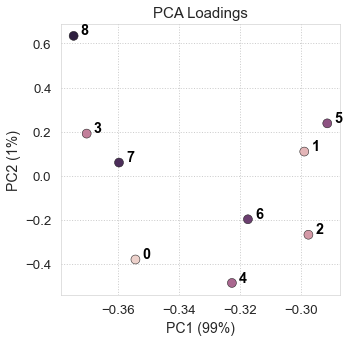

In [35]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.scatterplot(x="PC1", y="PC2", data=dLoad_, hue="Cluster", ax=ax, s=80, **{'linewidth':.5, 'edgecolor':"k"})
for line in range(0, dLoad_.shape[0]):
     ax.text(dLoad_.iloc[line, 0]+0.005, dLoad_.iloc[line, 1]+0.005, dLoad_["Cluster"][line], horizontalalignment='right', size='medium', color='black', weight='semibold')
ax.legend().remove()
ax.set_title("PCA Loadings", fontsize=15)
ax.set_xlabel("PC1 (" + str(int(varExp[0] * 100)) + "%)", fontsize=14)
ax.set_ylabel("PC2 (" + str(int(varExp[1] * 100)) + "%)", fontsize=14);
# plt.savefig("PCA_CPTAC_20cl_Loadings.svg", bbox_inches='tight', format='svg', dpi=1200)

#### WHITE Lab

In [36]:
for i in range(2, White_X.shape[1]):
    White_X.iloc[:, i] = pd.to_numeric(White_X.iloc[:, i], errors="ignore")

In [37]:
Wd = White_X.iloc[:, 2:].T
Wi = White_X.iloc[:, :2]

In [38]:
w_model = MassSpecClustering(Wi, ncl, SeqWeight=SeqWeight, distance_method=distance_method, n_runs=1).fit(Wd, "NA")

GMM initialized


In [39]:
Wcenters = w_model.transform(Wd).T

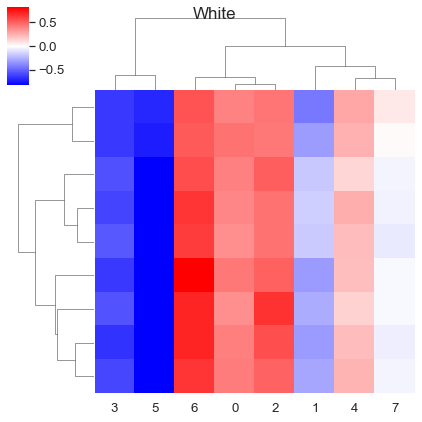

In [40]:
plotClustergram(Wcenters, "White", max(np.max(np.abs(Wcenters))) * 0.8, figsize=(6,6))

#### Cluster Averages

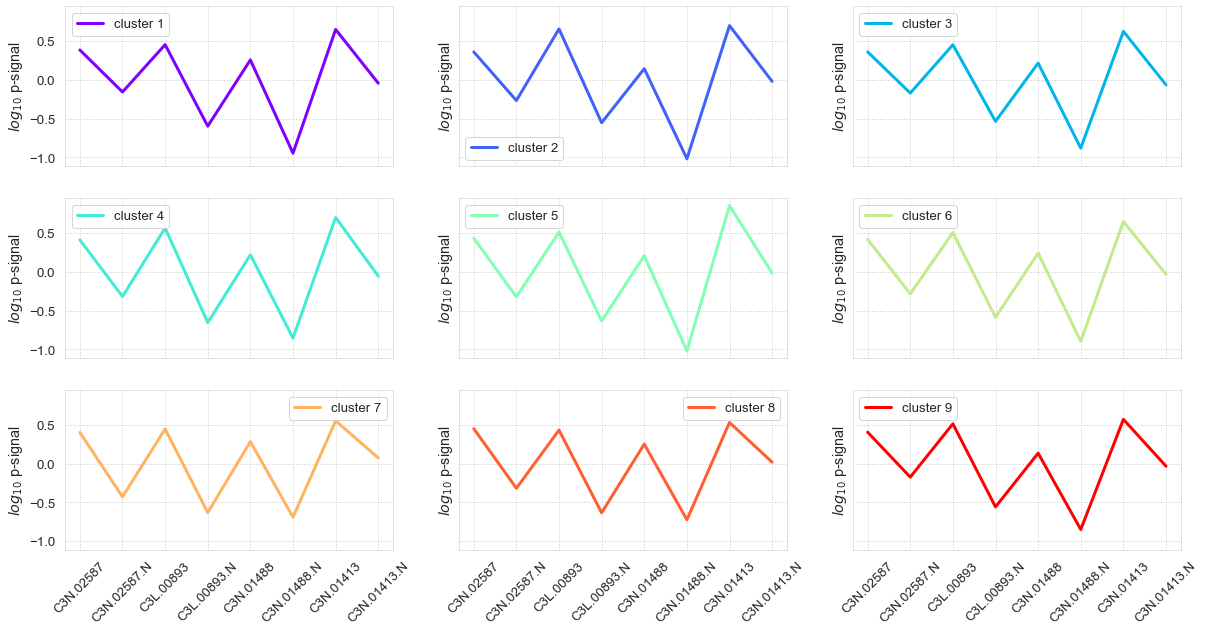

In [41]:
plotclustersIndividually(Wcenters, X_white.columns[2:], 3, 3)

#### PCA

In [42]:
Wcenters = Wcenters.T

In [43]:
Wcenters["Patient_ID"] = X_white.columns[2:]

In [44]:
c=2
pp = PCA(n_components=c)
dScor_ = pp.fit_transform(Wcenters.iloc[:, :-1])
dLoad_ = pp.components_
dScor_, dLoad_ = pca_dfs(dScor_, dLoad_, Wcenters, c, ["Patient_ID"], "Cluster")

In [45]:
dScor_.columns = ["PC1", "PC2", "Patient_ID"]

In [46]:
varExp = np.round(pp.explained_variance_ratio_, 2)
varExp

array([0.99, 0.01])

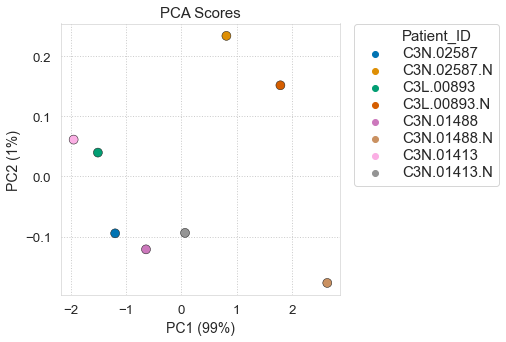

In [47]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.scatterplot(x="PC1", y="PC2", data=dScor_, hue="Patient_ID", ax=ax, s=80, **{'linewidth':.5, 'edgecolor':"k"})
ax.set_title("PCA Scores", fontsize=15)
ax.set_xlabel("PC1 (" + str(int(varExp[0] * 100)) + "%)", fontsize=14)
ax.set_ylabel("PC2 (" + str(int(varExp[1] * 100)) + "%)", fontsize=14)
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0, labelspacing=0.2, fontsize=15);
# plt.savefig("PCA_CPTAC_20cl_Scores.svg", bbox_inches='tight', format='svg', dpi=1200)

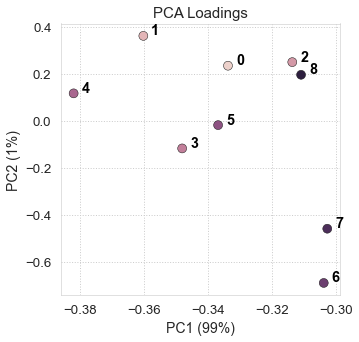

In [48]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.scatterplot(x="PC1", y="PC2", data=dLoad_, hue="Cluster", ax=ax, s=80, **{'linewidth':.5, 'edgecolor':"k"})
for line in range(0, dLoad_.shape[0]):
     ax.text(dLoad_.iloc[line, 0]+0.005, dLoad_.iloc[line, 1]+0.005, dLoad_["Cluster"][line], horizontalalignment='right', size='medium', color='black', weight='semibold')
ax.legend().remove()
ax.set_title("PCA Loadings", fontsize=15)
ax.set_xlabel("PC1 (" + str(int(varExp[0] * 100)) + "%)", fontsize=14)
ax.set_ylabel("PC2 (" + str(int(varExp[1] * 100)) + "%)", fontsize=14);
# plt.savefig("PCA_CPTAC_20cl_Loadings.svg", bbox_inches='tight', format='svg', dpi=1200)

## Distribution of Missingness

In [49]:
p_nan_counts = []
for i in range(d.shape[1]):
    p_nan_counts.append(np.count_nonzero(np.isnan(d[i])))

distribution mean: 152.76464620248686


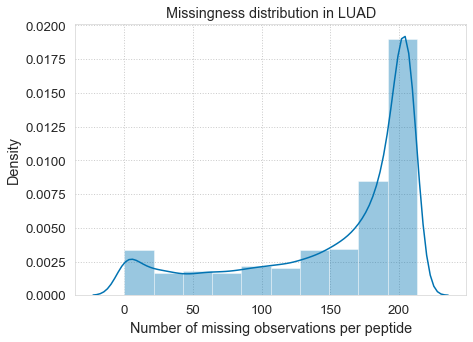

In [50]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
ax = sns.distplot(p_nan_counts, 10)
ax.set_title("Missingness distribution in LUAD")
ax.set_ylabel("Density")
ax.set_xlabel("Number of missing observations per peptide")

print("distribution mean:", np.mean(p_nan_counts))

## Artificial Missingness

Hypothesis: The sequence motif helps to correctly assign peptides to representative clusters, particularly at higher levels of missingness.

Approach: Introduce artificial missing data by leaving values out, and then seeing how well that values are represented by the corresponding clusters.

In [51]:
cd = filter_NaNpeptides(X, cut=1)
assert True not in np.isnan(cd.iloc[:, 4:]), "There are still NaNs."
cd.head()

,Sequence,Protein,Gene,Position,C3N.01799,C3N.01799.N,C3L.01890,C3L.01890.N,C3N.00572,C3N.00572.N,C3N.02423,C3N.02423.N,C3N.02729,C3N.02729.N,C3L.00263,...,C3N.00738,C3N.00738.N,C3N.00959,C3N.00959.N,C3N.02003,C3N.02003.N,C3N.02379.N,C3N.00175,C3N.00175.N,C3N.01823,C3N.01823.N,C3L.02549,C3L.02549.N,C3L.02365,C3L.02365.N
17,AAAFPsACGKT,NP_004554.3,PCK2,S304-p,0.369009,-0.648373,-0.553806,-0.076537,0.164563,-0.874365,-0.332726,-0.390048,3.468255,-0.333105,0.221374,...,0.339118,0.133446,-0.169312,-1.728890,-0.299966,-0.013774,-0.648569,1.415158,-0.427166,0.434367,0.316669,0.287304,-0.171400,0.147777,0.808027
19,AAAGDsDEESR,NP_001304919.1,ZBTB7A,S337-p,0.987832,-0.589544,0.753296,0.334983,0.097229,-0.211490,0.441904,-0.661843,0.786587,-0.502210,0.938446,...,-0.071544,-0.586586,0.900935,-1.839045,0.473805,-0.253002,-0.750325,-0.404800,-0.936916,0.437857,-0.593500,1.410095,-0.219179,0.781463,-0.259864
101,AAGGNsREPsP,NP_005985.3,TBX2,S653-p;S657-p,-0.028946,0.145179,-1.035176,-0.012889,0.038098,0.369007,-1.298905,0.807635,-0.686067,0.541639,-0.193468,...,-0.034454,-0.281349,-0.361043,-0.946628,-1.029561,0.811907,0.293287,-1.075322,-1.962043,-1.101506,-0.343776,0.357369,0.647509,-0.086769,-0.245152
118,AAGTLsPPGPE,NP_002212.3,ITPKB,S120-p,0.106153,-0.433158,-1.094319,-0.792549,0.222239,-0.059150,0.477218,0.478989,0.144265,-0.312665,-0.323495,...,0.612627,-0.165410,0.220120,-0.377634,-0.446208,-0.096869,-0.734171,0.449283,-0.977510,0.281571,0.209954,0.572213,-0.139567,0.641356,-0.395030
142,AAKPGsPQAKS,NP_001305253.1;NP_005076.3,NUP214,S678-p,0.748657,-0.836795,-0.085079,-0.876992,0.265370,-0.520252,0.610473,-0.855972,0.729199,-1.172399,0.477952,...,0.564282,-0.491627,0.089167,-0.828384,0.196005,-0.335444,-0.674635,0.277463,-0.718798,0.482927,-0.558413,0.567970,-0.639330,0.737999,-0.644100


Generate data sets with 5%, 10%, 20%, 40%, 60%, 80%, 90% missingness:

In [53]:
nan_per = [0.05, 0.1, 0.2, 0.4, 0.6, 0.8, 0.9]
weights = [0, 25, 1000]
ncl = 5

am = ArtificialMissingness(cd, weights, nan_per, "PAM250", ncl)

Artificial missingness % : 0.05
weight: 0
GMM initialized
Re-initialize GMM clusters, empty cluster(s) at iteration 0
Re-initialize GMM clusters, empty cluster(s) at iteration 1
Re-initialize GMM clusters, empty cluster(s) at iteration 2
Re-initialize GMM clusters, empty cluster(s) at iteration 3
Re-initialize GMM clusters, empty cluster(s) at iteration 4
SeqWins: 0 DataWins: 934 BothWin: 377 MixWin: 0
weight: 25
GMM initialized
SeqWins: 307 DataWins: 648 BothWin: 352 MixWin: 4
weight: 1000
GMM initialized
SeqWins: 965 DataWins: 4 BothWin: 342 MixWin: 0
Artificial missingness % : 0.1
weight: 0
GMM initialized
SeqWins: 0 DataWins: 902 BothWin: 409 MixWin: 0
weight: 25
GMM initialized
SeqWins: 58 DataWins: 910 BothWin: 342 MixWin: 1
weight: 1000
GMM initialized
SeqWins: 984 DataWins: 2 BothWin: 325 MixWin: 0
Artificial missingness % : 0.2
weight: 0
GMM initialized
SeqWins: 0 DataWins: 942 BothWin: 369 MixWin: 0
weight: 25
GMM initialized
SeqWins: 599 DataWins: 388 BothWin: 322 MixWin: 2


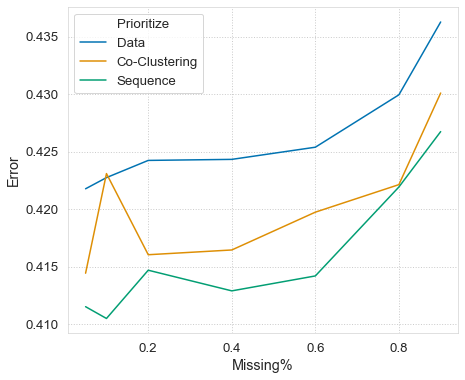

In [54]:
fig, ax = plt.subplots(1, 1, figsize=(7, 6))
sns.lineplot(x="Missing%", y="Error", data=am, hue="Prioritize")

In [57]:
# %%time
# model = MassSpecClustering(i_w, ncl, SeqWeight=500, distance_method="PAM250", n_runs=1).fit(d_w, "NA")
# model.wins_

## Weight Variation

Plot sequence, data, both, and mix wins with different SequenceWeights

In [82]:
X_w = filter_NaNpeptides(X, cut=0.5)
d_w = X_w.select_dtypes(include=['float64']).T
i_w = X_w.select_dtypes(include=['object'])

In [ ]:
%%time
weights = np.arange(0, 500, 50)
ww = WinsByWeight(i_w, d_w, weights, "PAM250")

0
GMM initialized
50
GMM initialized
100
GMM initialized
150
GMM initialized
200
GMM initialized
250
GMM initialized
300
GMM initialized


In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(7, 6))
sns.lineplot(x="Sequence_Weighting", y="Wins", data=am, hue="Prioritize")

In [ ]:
raise SystemExit

## Run Model

### Filter peptides based on a threshold of missingness

In [ ]:
X_f = filter_NaNpeptides(X, cut=0.1)
d_f = X_f.select_dtypes(include=['float64']).T
i_f = X_f.select_dtypes(include=['object'])

Reduce data set:

In [ ]:
# Reduce data set?
# npept = 7000
# d = d.iloc[:, :npept]
# i = i.iloc[:npept, :]

#Drop NaN?
# d = d.iloc[:8, :].dropna(axis=1)
# i = i.iloc[d.columns, :]

Run model:

In [ ]:
# %%time
# distance_method = "PAM250"
# ncl = 20
# SeqWeight = 50

# MSC = MassSpecClustering(i_f, ncl, SeqWeight=SeqWeight, distance_method=distance_method, n_runs=1).fit(d_f, "NA")

Save model:

In [ ]:
# with open('CPTACmodel', 'wb') as f:
#     pickle.dump([MSC], f)

Load if necessary:

In [ ]:
with open('CPTACmodel_w50S_c20', 'rb') as f:
    MSC = pickle.load(f)[0]

## Hierarchical Clustering

In [ ]:
centers = MSC.transform(d_f)
centers["Patient_ID"] = X.columns[4:]

In [ ]:
centers = centers.set_index(["Patient_ID"])
plotClustergram(centers, "", lim=max(np.max(np.abs(centers)) * 0.5), figsize=(10, 10), yticklabels=True)
centers = centers.reset_index()
# plt.savefig("CPTAC_GMM.svg", bbox_inches='tight', format='svg', dpi=1200)

## Regression against Clinical Features

Import 2y-Survival data:

In [ ]:
cf = pd.read_csv("msresist/data/MS/CPTAC/Y_CPTAC.csv").drop("Metastasis", axis=1)
cf_ = cf.replace("Living", 0)
cf_ = cf_.replace("Deceased", 1)
cf_ = cf_.replace("No", 0)
cf_ = cf_.replace("Yes", 1)

In [ ]:
cf_.shape

Import patient accessions to match signaling with clinical data:

In [ ]:
IDict = pd.read_csv("msresist/data/MS/CPTAC/IDs.csv", header=0)
IDict_ = dict(zip(IDict.iloc[:, 0], IDict.iloc[:, 1]))

Change patient IDs from Case ID to Broad ID:

In [ ]:
ids = []
for i in range(cf.shape[0]):
    ids.append(IDict_[cf_.iloc[i, 0]])
cf_["Patient_ID"] = ids

Add Tumor row per patient:

In [ ]:
for i in range(cf_.shape[0]):
    id_ = cf_.iloc[i, 0].split(".N")[0]
    cf_.loc[-1] = [id_, cf_.iloc[i, 1]]
    cf_.index = cf_.index + 1
cf_.loc[-1] = ["C3N.02379.1", 0]
cf_.index = cf_.index + 1
cf_ = cf_.sort_index()

In [ ]:
centers.head()

In [ ]:
centers = centers.set_index("Patient_ID").drop(["C3N.02587", "C3N.02587.N"], axis=0).sort_values(by="Patient_ID")
y = pd.read_csv("msresist/data/MS/CPTAC/y.csv").sort_values(by="Patient_ID").set_index("Patient_ID")

### R2Y/Q2Y

In [ ]:
p1 = PLSRegression(n_components=2, scale=False)
fig, ax = plt.subplots(1, 1, figsize=(7,6))
plotR2YQ2Y(ax, p1, centers, y, 1, 10)

In [ ]:
centers = centers.reset_index()

## PCA Analysis

In [ ]:
c=2
pp = PCA(n_components=c)
dScor_ = pp.fit_transform(centers.iloc[:, 1:])
dLoad_ = pp.components_
dScor_, dLoad_ = pca_dfs(dScor_, dLoad_, centers, c, ["Patient_ID"], "Cluster")

In [ ]:
dScor_.columns = ["PC1", "PC2", "Patient_ID"]

In [ ]:
tumortype = []
for i in range(dScor_.shape[0]):
    if ".N" in dScor_["Patient_ID"][i]:
        tumortype.append("Normal")
    else:
        tumortype.append("Tumor")

In [ ]:
dScor_["Type"] = tumortype

In [ ]:
varExp = np.round(pp.explained_variance_ratio_, 2)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
sns.scatterplot(x="PC1", y="PC2", data=dScor_, hue="Type", style="Type", ax=ax, s=80, **{'linewidth':.5, 'edgecolor':"k"})
ax.set_title("PCA Scores", fontsize=15)
ax.set_xlabel("PC1 (" + str(int(varExp[0] * 100)) + "%)", fontsize=14)
ax.set_ylabel("PC2 (" + str(int(varExp[1] * 100)) + "%)", fontsize=14)
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0, labelspacing=0.2, fontsize=15);
# plt.savefig("PCA_CPTAC_20cl_Scores.svg", bbox_inches='tight', format='svg', dpi=1200)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
sns.scatterplot(x="PC1", y="PC2", data=dLoad_, hue="Cluster", ax=ax, s=80, **{'linewidth':.5, 'edgecolor':"k"})
for line in range(0, dLoad_.shape[0]):
     ax.text(dLoad_.iloc[line, 0]+0.001, dLoad_.iloc[line, 1]+0.009, dLoad_["Cluster"][line], horizontalalignment='right', size='medium', color='black', weight='semibold')
ax.legend().remove()
ax.set_title("PCA Loadings", fontsize=15)
ax.set_xlabel("PC1 (" + str(int(varExp[0] * 100)) + "%)", fontsize=14)
ax.set_ylabel("PC2 (" + str(int(varExp[1] * 100)) + "%)", fontsize=14);
# plt.savefig("PCA_CPTAC_20cl_Loadings.svg", bbox_inches='tight', format='svg', dpi=1200)

In [ ]:
clustermembers = MSC.clustermembers(X_f.T)
clustermembers.head(5)